In [1]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import time


In [3]:
# Load the dataset 
df = pd.read_csv("Reviews.csv")

In [4]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df_nan= df[df.isna().any(axis=1)]
df_nan.shape

(53, 10)

In [6]:
df = df.dropna()
df.shape

(568401, 10)

In [7]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

In [8]:
# Initialize RoBERTa
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
roberta_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [9]:
# Set chunk size for processing
chunk_size = 3000

# Split the DataFrame into chunks for processing (for large datasets)
chunks = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]


In [10]:
# Initialize dictionaries for storing results and timing
vader_results = {}
roberta_results = {}
vader_times = []
roberta_times = []


In [23]:
# Process data in chunks to avoid memory issues
for i, chunk in tqdm(enumerate(chunks), total=len(chunks)):
    for _, row in chunk.iterrows():
        text = row['Text']
        myid = row['Id']
        
        # Compute VADER sentiment scores and track time
        vader_start_time = time.time()
        vader_scores = sia.polarity_scores(text)
        vader_end_time = time.time()
        vader_results[myid] = vader_scores
        vader_times.append(vader_end_time - vader_start_time)
        
        
        # Compute RoBERTa sentiment scores and track time
        roberta_start_time = time.time()
        try:
            roberta_scores = roberta_pipeline(text)
            roberta_label = roberta_scores[0]['label']
            roberta_score = roberta_scores[0]['score']  # Extract score
        except Exception as e:
            roberta_label = "ERROR"
            roberta_score = None  # Assign None if there's an error
        roberta_end_time = time.time()
        
        # Store both label and score in the results
        roberta_results[myid] = {"label": roberta_label, "score": roberta_score}
        # Append RoBERTa time
        roberta_times.append(roberta_end_time - roberta_start_time)


  0%|          | 0/190 [00:00<?, ?it/s]

In [46]:
# Convert VADER results into a DataFrame
vaders = pd.DataFrame(vader_results).T
vaders = vaders.reset_index().rename(columns={"index": "Id"})

# Store both label and score in the results
roberta_results[myid] = {"label": roberta_label, "score": roberta_score}

# Convert RoBERTa results into a DataFrame including both label and score
roberta_df = pd.DataFrame(
    [{"Id": k, "roberta_sentiment": v["label"], "roberta_score": v["score"]} for k, v in roberta_results.items()]
)

# Merge results with the original DataFrame
results = df.merge(vaders, on="Id", how="left")
results = results.merge(roberta_df, on="Id", how="left")

# Add timing information
results['vader_time'] = vader_times[:len(results)]
results['roberta_time'] = roberta_times[:len(results)]



In [44]:
print(len(vader_times), len(roberta_times), len(results))


1429791 569158 568401


In [45]:
results['vader_time'] = vader_times[:len(results)]
results['roberta_time'] = roberta_times[:len(results)]


In [47]:
results.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,neg,neu,pos,compound,roberta_sentiment,roberta_score,vader_time,roberta_time
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.000,0.695,0.305,0.9441,LABEL_2,0.940395,0.002196,0.868310
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.138,0.862,0.000,-0.5664,LABEL_0,0.508986,0.000309,0.042176
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.091,0.754,0.155,0.8265,LABEL_2,0.898704,0.000922,0.046202
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.000,1.000,0.000,0.0000,LABEL_2,0.907486,0.000213,0.030072
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.000,0.552,0.448,0.9468,LABEL_2,0.988063,0.000185,0.028975


In [48]:
# Categorize VADER sentiments based on compound score
def categorize_vader_sentiment(compound):
    if compound >= 0.05:
        return 'pos'  # Positive sentiment
    elif compound <= -0.05:
        return 'neg'  # Negative sentiment
    else:
        return 'neu'  # Neutral sentiment
        
results['vader_sentiment'] = results['compound'].apply(categorize_vader_sentiment)


In [49]:
# Map RoBERTa labels to standard sentiment categories
roberta_sentiment_mapping = {
    "LABEL_0": "neg",
    "LABEL_1": "neu",
    "LABEL_2": "pos"
}
results['roberta_sentiment'] = results['roberta_sentiment'].replace(roberta_sentiment_mapping)


In [50]:
# Define the function to map star ratings to sentiment labels
def map_score_to_sentiment(score):
    if score in [1, 2]:
        return 'neg'  # Negative sentiment
    elif score == 3:
        return 'neu'  # Neutral sentiment
    elif score in [4, 5]:
        return 'pos'  # Positive sentiment

# Apply the function to create a new column for star sentiment
results['star_sentiment'] = results['Score'].apply(map_score_to_sentiment)


In [51]:
# Count the sentiment distribution for VADER
vader_sentiment_counts = results['vader_sentiment'].value_counts()
print("VADER Sentiment Distribution:")
print(vader_sentiment_counts)

# Count the sentiment distribution for RoBERTa
roberta_sentiment_counts = results['roberta_sentiment'].value_counts()
print("\nRoBERTa Sentiment Distribution:")
print(roberta_sentiment_counts)

# Count the sentiment distribution for Star Ratings
star_sentiment_counts = results['star_sentiment'].value_counts()
print("\nStar Sentiment Distribution:")
print(star_sentiment_counts)


VADER Sentiment Distribution:
vader_sentiment
pos    496950
neg     59309
neu     12142
Name: count, dtype: int64

RoBERTa Sentiment Distribution:
roberta_sentiment
pos      435911
neg       86585
neu       39900
ERROR      6005
Name: count, dtype: int64

Star Sentiment Distribution:
star_sentiment
pos    443756
neg     82007
neu     42638
Name: count, dtype: int64


In [52]:
# Calculate accuracy for VADER and RoBERTa
vader_accuracy = (results['vader_sentiment'] == results['star_sentiment']).mean() * 100
roberta_accuracy = (results["roberta_sentiment"] == results['star_sentiment']).mean() * 100


In [53]:
# Display results
print(f"Accuracy of VADER model compared to star ratings: {vader_accuracy:.2f}%")
print(f"Accuracy of RoBERTa model compared to star ratings: {roberta_accuracy:.2f}%")
print(f"Average processing time per review for VADER: {sum(vader_times) / len(vader_times):.4f} seconds")
print(f"Average processing time per review for RoBERTa: {sum(roberta_times) / len(roberta_times):.4f} seconds")


Accuracy of VADER model compared to star ratings: 79.70%
Accuracy of RoBERTa model compared to star ratings: 83.91%
Average processing time per review for VADER: 0.0017 seconds
Average processing time per review for RoBERTa: 0.1344 seconds


In [54]:
# Optional: Display the first few rows for manual inspection
print(results[['Id', 'compound', 'vader_sentiment','roberta_score', 'roberta_sentiment', 'star_sentiment', 'Text', 'vader_time', 'roberta_time']].head())

   Id  compound vader_sentiment  roberta_score roberta_sentiment  \
0   1    0.9441             pos       0.940395               pos   
1   2   -0.5664             neg       0.508986               neg   
2   3    0.8265             pos       0.898704               pos   
3   4    0.0000             neu       0.907486               pos   
4   5    0.9468             pos       0.988063               pos   

  star_sentiment                                               Text  \
0            pos  I have bought several of the Vitality canned d...   
1            neg  Product arrived labeled as Jumbo Salted Peanut...   
2            pos  This is a confection that has been around a fe...   
3            neg  If you are looking for the secret ingredient i...   
4            pos  Great taffy at a great price.  There was a wid...   

   vader_time  roberta_time  
0    0.002196      0.868310  
1    0.000309      0.042176  
2    0.000922      0.046202  
3    0.000213      0.030072  
4    0.000185 

In [55]:
#Checking VADER positive
print(sia.polarity_scores("I'm happy"))
#Checking VADER negative
print(sia.polarity_scores("I'm sad."))
print(sia.polarity_scores("I'm happy!"))
print(sia.polarity_scores("I'm so happy."))
print(sia.polarity_scores("I'm so HAPPY."))
print(sia.polarity_scores("I'm happy :)"))

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
{'neg': 0.0, 'neu': 0.2, 'pos': 0.8, 'compound': 0.6114}
{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}
{'neg': 0.0, 'neu': 0.297, 'pos': 0.703, 'compound': 0.6933}
{'neg': 0.0, 'neu': 0.13, 'pos': 0.87, 'compound': 0.7717}


In [56]:
#Checking Roberta positive
print(roberta_pipeline("I'm happy."))
#Checking Roberta negative
print(roberta_pipeline("I'm sad."))
print(roberta_pipeline("I'm happy!"))
print(roberta_pipeline("I'm so happy."))
print(roberta_pipeline("I'm so HAPPY."))
print(roberta_pipeline("I'm happy :)"))

[{'label': 'LABEL_2', 'score': 0.9751206636428833}]
[{'label': 'LABEL_0', 'score': 0.880328893661499}]
[{'label': 'LABEL_2', 'score': 0.9856088757514954}]
[{'label': 'LABEL_2', 'score': 0.9883331656455994}]
[{'label': 'LABEL_2', 'score': 0.9882978796958923}]
[{'label': 'LABEL_2', 'score': 0.983936071395874}]


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

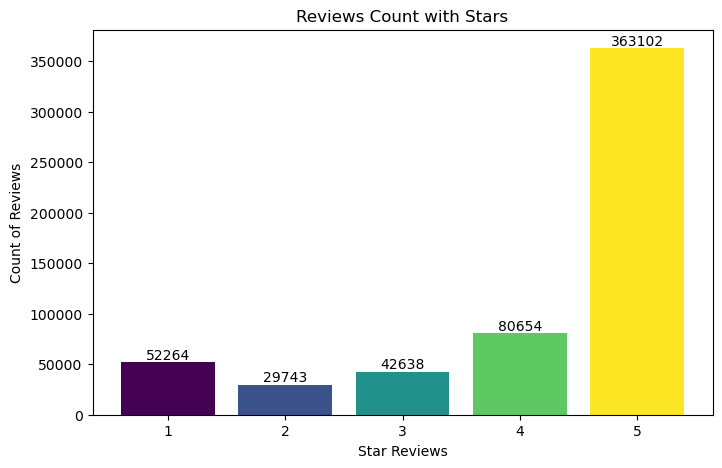

In [58]:
counts= df["Score"].value_counts().sort_index()# Count the number of reviews for each score

#Create the plot
fig,ax = plt.subplots(figsize=(8,5))
colors= plt.cm.viridis(np.linspace(0,1, len(counts)))
bars= ax.bar(counts.index, counts.values, color=colors)

#Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 10,  # Adjust position
     f"{int(height)}", ha = "center", va="bottom", fontsize=10)

#Customize the plot
ax.set_xlabel("Star Reviews")
ax.set_ylabel("Count of Reviews")
ax.set_title("Reviews Count with Stars")
plt.show()

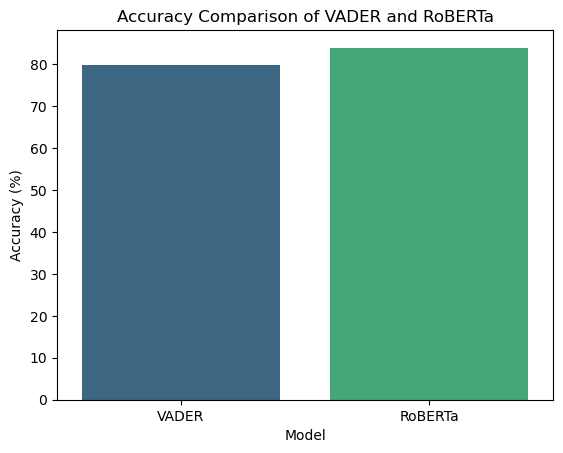

In [59]:
# Accuracy Comparison Plot
accuracy_data = pd.DataFrame({
    "Model": ["VADER", "RoBERTa"],
    "Accuracy (%)": [vader_accuracy, roberta_accuracy]
})
sns.barplot(
    x="Model", 
    y="Accuracy (%)", 
    data=accuracy_data, 
    palette="viridis", 
    hue="Model", 
    dodge=False  # Ensures bars aren't split since we use `hue`
)
plt.title("Accuracy Comparison of VADER and RoBERTa")
plt.ylabel("Accuracy (%)")
plt.xlabel("Model")
plt.legend([], [], frameon=False)  # Remove the redundant legend
plt.show()


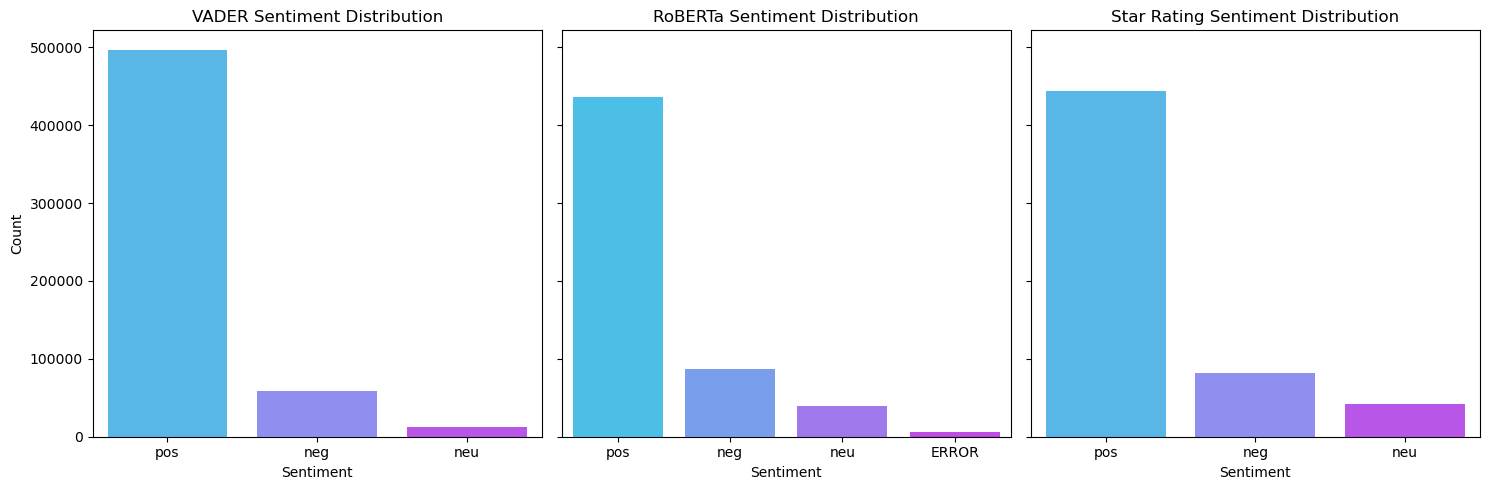

In [60]:
# Sentiment Distribution Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# VADER Sentiment Distribution
sns.countplot(x='vader_sentiment', data=results, ax=axes[0], palette="cool", hue="vader_sentiment")
axes[0].set_title("VADER Sentiment Distribution")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count")

# RoBERTa Sentiment Distribution
sns.countplot(x='roberta_sentiment', data=results, ax=axes[1], palette="cool", hue="roberta_sentiment")
axes[1].set_title("RoBERTa Sentiment Distribution")
axes[1].set_xlabel("Sentiment")

# Star Rating Sentiment Distribution
sns.countplot(x='star_sentiment', data=results, ax=axes[2], palette="cool", hue="star_sentiment")
axes[2].set_title("Star Rating Sentiment Distribution")
axes[2].set_xlabel("Sentiment")

plt.tight_layout()
plt.show()


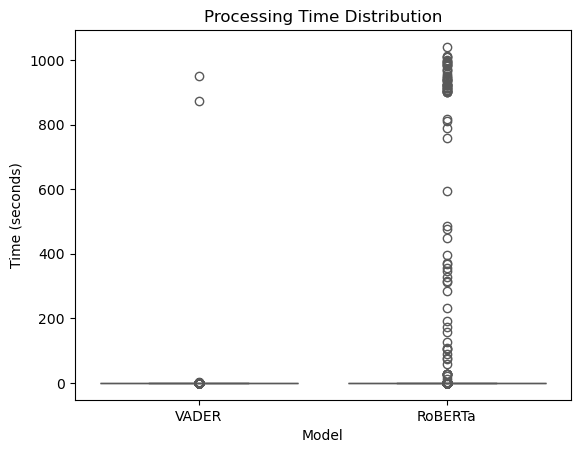

In [61]:
# Processing Time Distribution
time_data = pd.DataFrame({
    "Model": ["VADER"] * len(vader_times) + ["RoBERTa"] * len(roberta_times),
    "Time (seconds)": vader_times + roberta_times
})

# Boxplot with 'hue' to avoid the warning
sns.boxplot(x="Model", y="Time (seconds)", data=time_data, palette="Set2", hue="Model")
plt.title("Processing Time Distribution")
plt.ylabel("Time (seconds)")
plt.xlabel("Model")
plt.show()


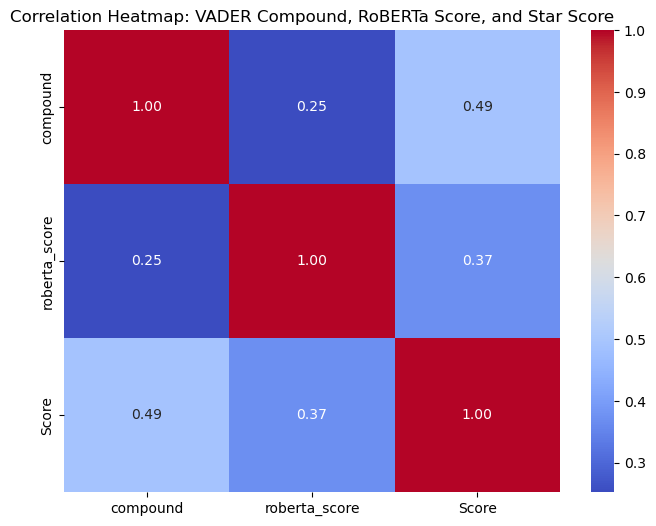

In [62]:


# Select the columns to calculate correlation
correlation_columns = ['compound', 'roberta_score', 'Score']

# Calculate the correlation matrix
correlation_matrix = results[correlation_columns].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap: VADER Compound, RoBERTa Score, and Star Score")
plt.show()


In [63]:
# Calculate total positive, neutral, and negative counts based on star ratings
star_sentiment_totals = results['star_sentiment'].value_counts()

# Calculate total positive, neutral, and negative counts based on VADER
vader_sentiment_totals = results['vader_sentiment'].value_counts()

# Calculate total positive, neutral, and negative counts based on RoBERTa
roberta_sentiment_totals = results['roberta_sentiment'].value_counts()

# Combine results into a DataFrame for easier comparison
sentiment_totals = pd.DataFrame({
    "Star Rating": star_sentiment_totals,
    "RoBERTa": roberta_sentiment_totals,
    "VADER": vader_sentiment_totals
}).fillna(0).astype(int)

print("Total Sentiment Counts:")
print(sentiment_totals)



Total Sentiment Counts:
       Star Rating  RoBERTa   VADER
ERROR            0     6005       0
neg          82007    86585   59309
neu          42638    39900   12142
pos         443756   435911  496950


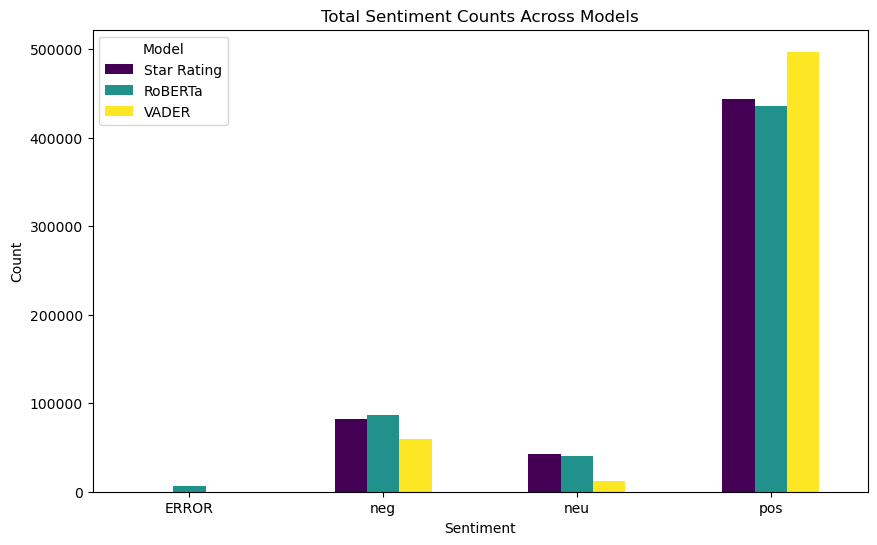

In [64]:
# Visualization for comparison
sentiment_totals.plot(kind='bar', figsize=(10, 6), colormap="viridis")
plt.title("Total Sentiment Counts Across Models")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.show()

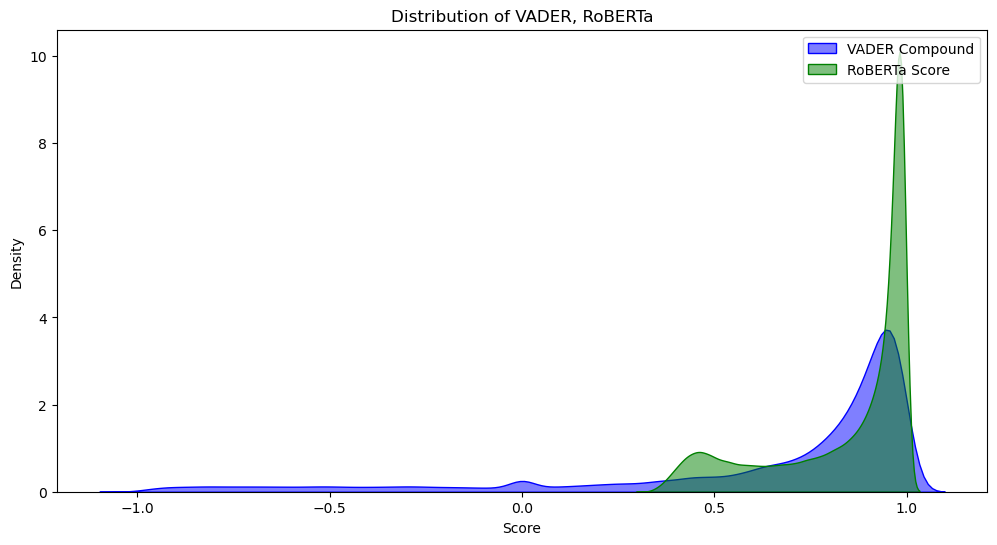

In [65]:


# Set the figure size for all three distributions
plt.figure(figsize=(12, 6))

# Plot the distribution of VADER compound score
sns.kdeplot(results['compound'], label="VADER Compound", fill=True, color="blue", alpha=0.5)

# Plot the distribution of RoBERTa score
sns.kdeplot(results['roberta_score'], label="RoBERTa Score", fill=True, color="green", alpha=0.5)

# Set titles and labels
plt.title("Distribution of VADER, RoBERTa")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()

# Show the plot
plt.show()

